In [1]:
import numpy as np
import cv2
from torch.utils.data import DataLoader # type: ignore
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
import random
from utils.dataset import ImageSet, transform
from utils.metrics import plot_metrics
from utils.utils import fix_colors

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/home/dominik/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/dominik/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/dominik/.local/lib/python3.12/site-packages/lpips/weights/v0.1/alex.pth


# OpenCV inpainting

In [2]:
def classic_inpaint(img, mask, radius=3):
    return cv2.inpaint(img, mask, inpaintRadius=radius, flags=cv2.INPAINT_TELEA) / 255

# Neural Network inpainting

### Dataset

In [7]:
train_dataset = ImageSet("data/inpainting/train", "data/intermediate/train", transform, impainting=True)
valid_dataset = ImageSet("data/inpainting/valid", "data/intermediate/valid", transform, impainting=True)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

### Model

In [8]:
class InpaintingCNN(nn.Module):
    def __init__(self):
        super(InpaintingCNN, self).__init__()

        # **Encoder** (Ekstrakcja cech)
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),  # 256 -> 128
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1), # 128 -> 64
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1), # 64 -> 32
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1), # 32 -> 16
            nn.ReLU()
        )

        # **Decoder** (Rekonstrukcja obrazu)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1), # 16 -> 32
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1), # 32 -> 64
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1), # 64 -> 128
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1, output_padding=1), # 128 -> 256
            nn.Sigmoid()  # Sigmoid, bo chcemy wartości w zakresie 0-1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [19]:
# model = InpaintingCNN()
# model.to(device)

# optimizer = optim.Adam(model.parameters(), lr=0.001)
# criterion = nn.MSELoss()

In [20]:
# import tqdm

# num_epochs = 10
# losses = {"train":[],"val":[]}


# for epoch in range(num_epochs):
#     model.train()
#     for x, y in tqdm.tqdm(train_dataloader):
#         optimizer.zero_grad()
#         x, y = x.to(device), y.to(device)

#         out = model(x)
        
#         loss = criterion(out, y)

#         loss.backward()
#         optimizer.step()
    
#     model.eval()
#     print(f"epoch #{epoch+1}, loss: {loss}")
#     losses["train"].append(loss)
#     with torch.no_grad():
#         total_loss = 0.0
#         for x, y in valid_dataset:
#             x, y = x.to(device), y.to(device)

#             out = model(x)

#             loss = criterion(out, y)


#             total_loss += loss.item()
#         print("Validation loss:",total_loss)
#     losses["val"].append(total_loss)

In [21]:
# x = range(num_epochs)
# y = losses['val']

# plt.plot(x, y)
# plt.ylabel("loss")
# plt.xlabel("epoch")
# plt.title("loss on valid")
# plt.show()

In [9]:
# torch.save(model, "model_inpainting.pth")

### Results

In [22]:
model = torch.load("model_inpainting.pth", weights_only=False)
# model.to(device)# 

In [23]:
def replace_black_squares(original: np.ndarray, inpainting: np.ndarray):
    black_mask = np.all(original == [0, 0, 0], axis=-1)

    result = original.copy()
    result[black_mask] = inpainting[black_mask]

    return result

Wybranie losowo 5 obrazów i porównanie z rozwiązaniem bazowym z biblioteki openCV

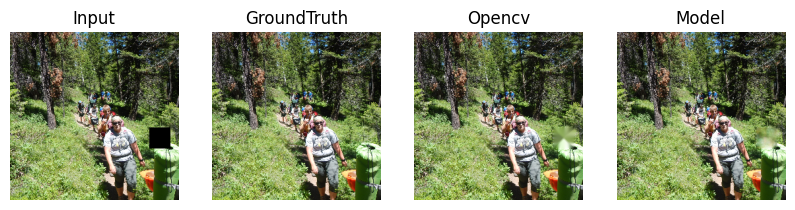

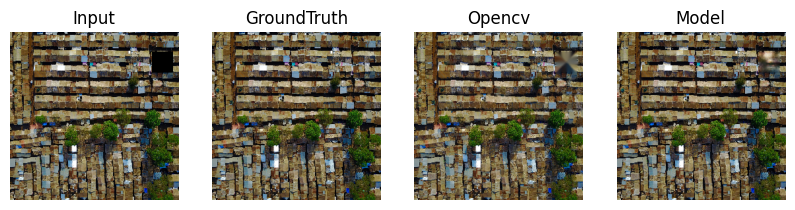

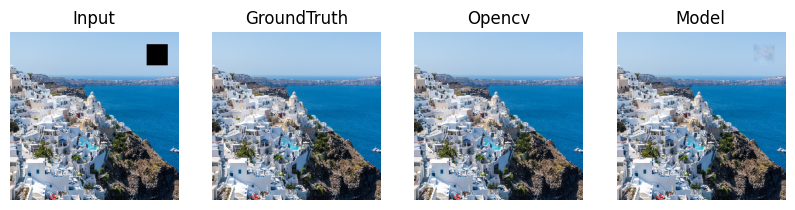

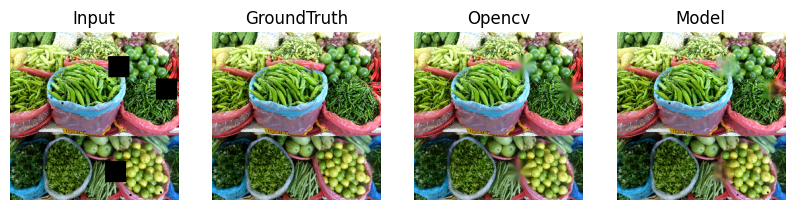

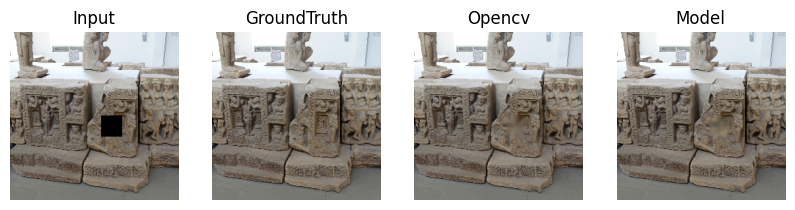

In [24]:
model.eval()

for i in range(5):
    a = random.choice(valid_dataset)

    dest = a[1].permute(1, 2, 0).detach().numpy()
    input = a[0].permute(1, 2, 0).detach().numpy()

    black_mask = (np.all(input < 0.05, axis=2)).astype(np.uint8) * 255
    image_uint8 = (input * 255).astype(np.uint8)
    out_opencv = cv2.inpaint(image_uint8, black_mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)
    # dest = denormalize(dest)

    out = model(a[0].to(device))
    out = out.permute(1, 2, 0).detach().cpu().numpy()
    out = replace_black_squares(input, out)

    fig, axes = plt.subplots(1, 4, figsize=(10, 5)) 

    axes[0].imshow(fix_colors(input))
    axes[0].axis('off')
    axes[0].set_title("Input")

    axes[1].imshow(fix_colors(dest))
    axes[1].axis('off')
    axes[1].set_title("GroundTruth")

    axes[2].imshow(fix_colors(out_opencv))
    axes[2].axis('off')
    axes[2].set_title("Opencv")

    axes[3].imshow(fix_colors(out))
    axes[3].axis('off')
    axes[3].set_title("Model")

### Metryki

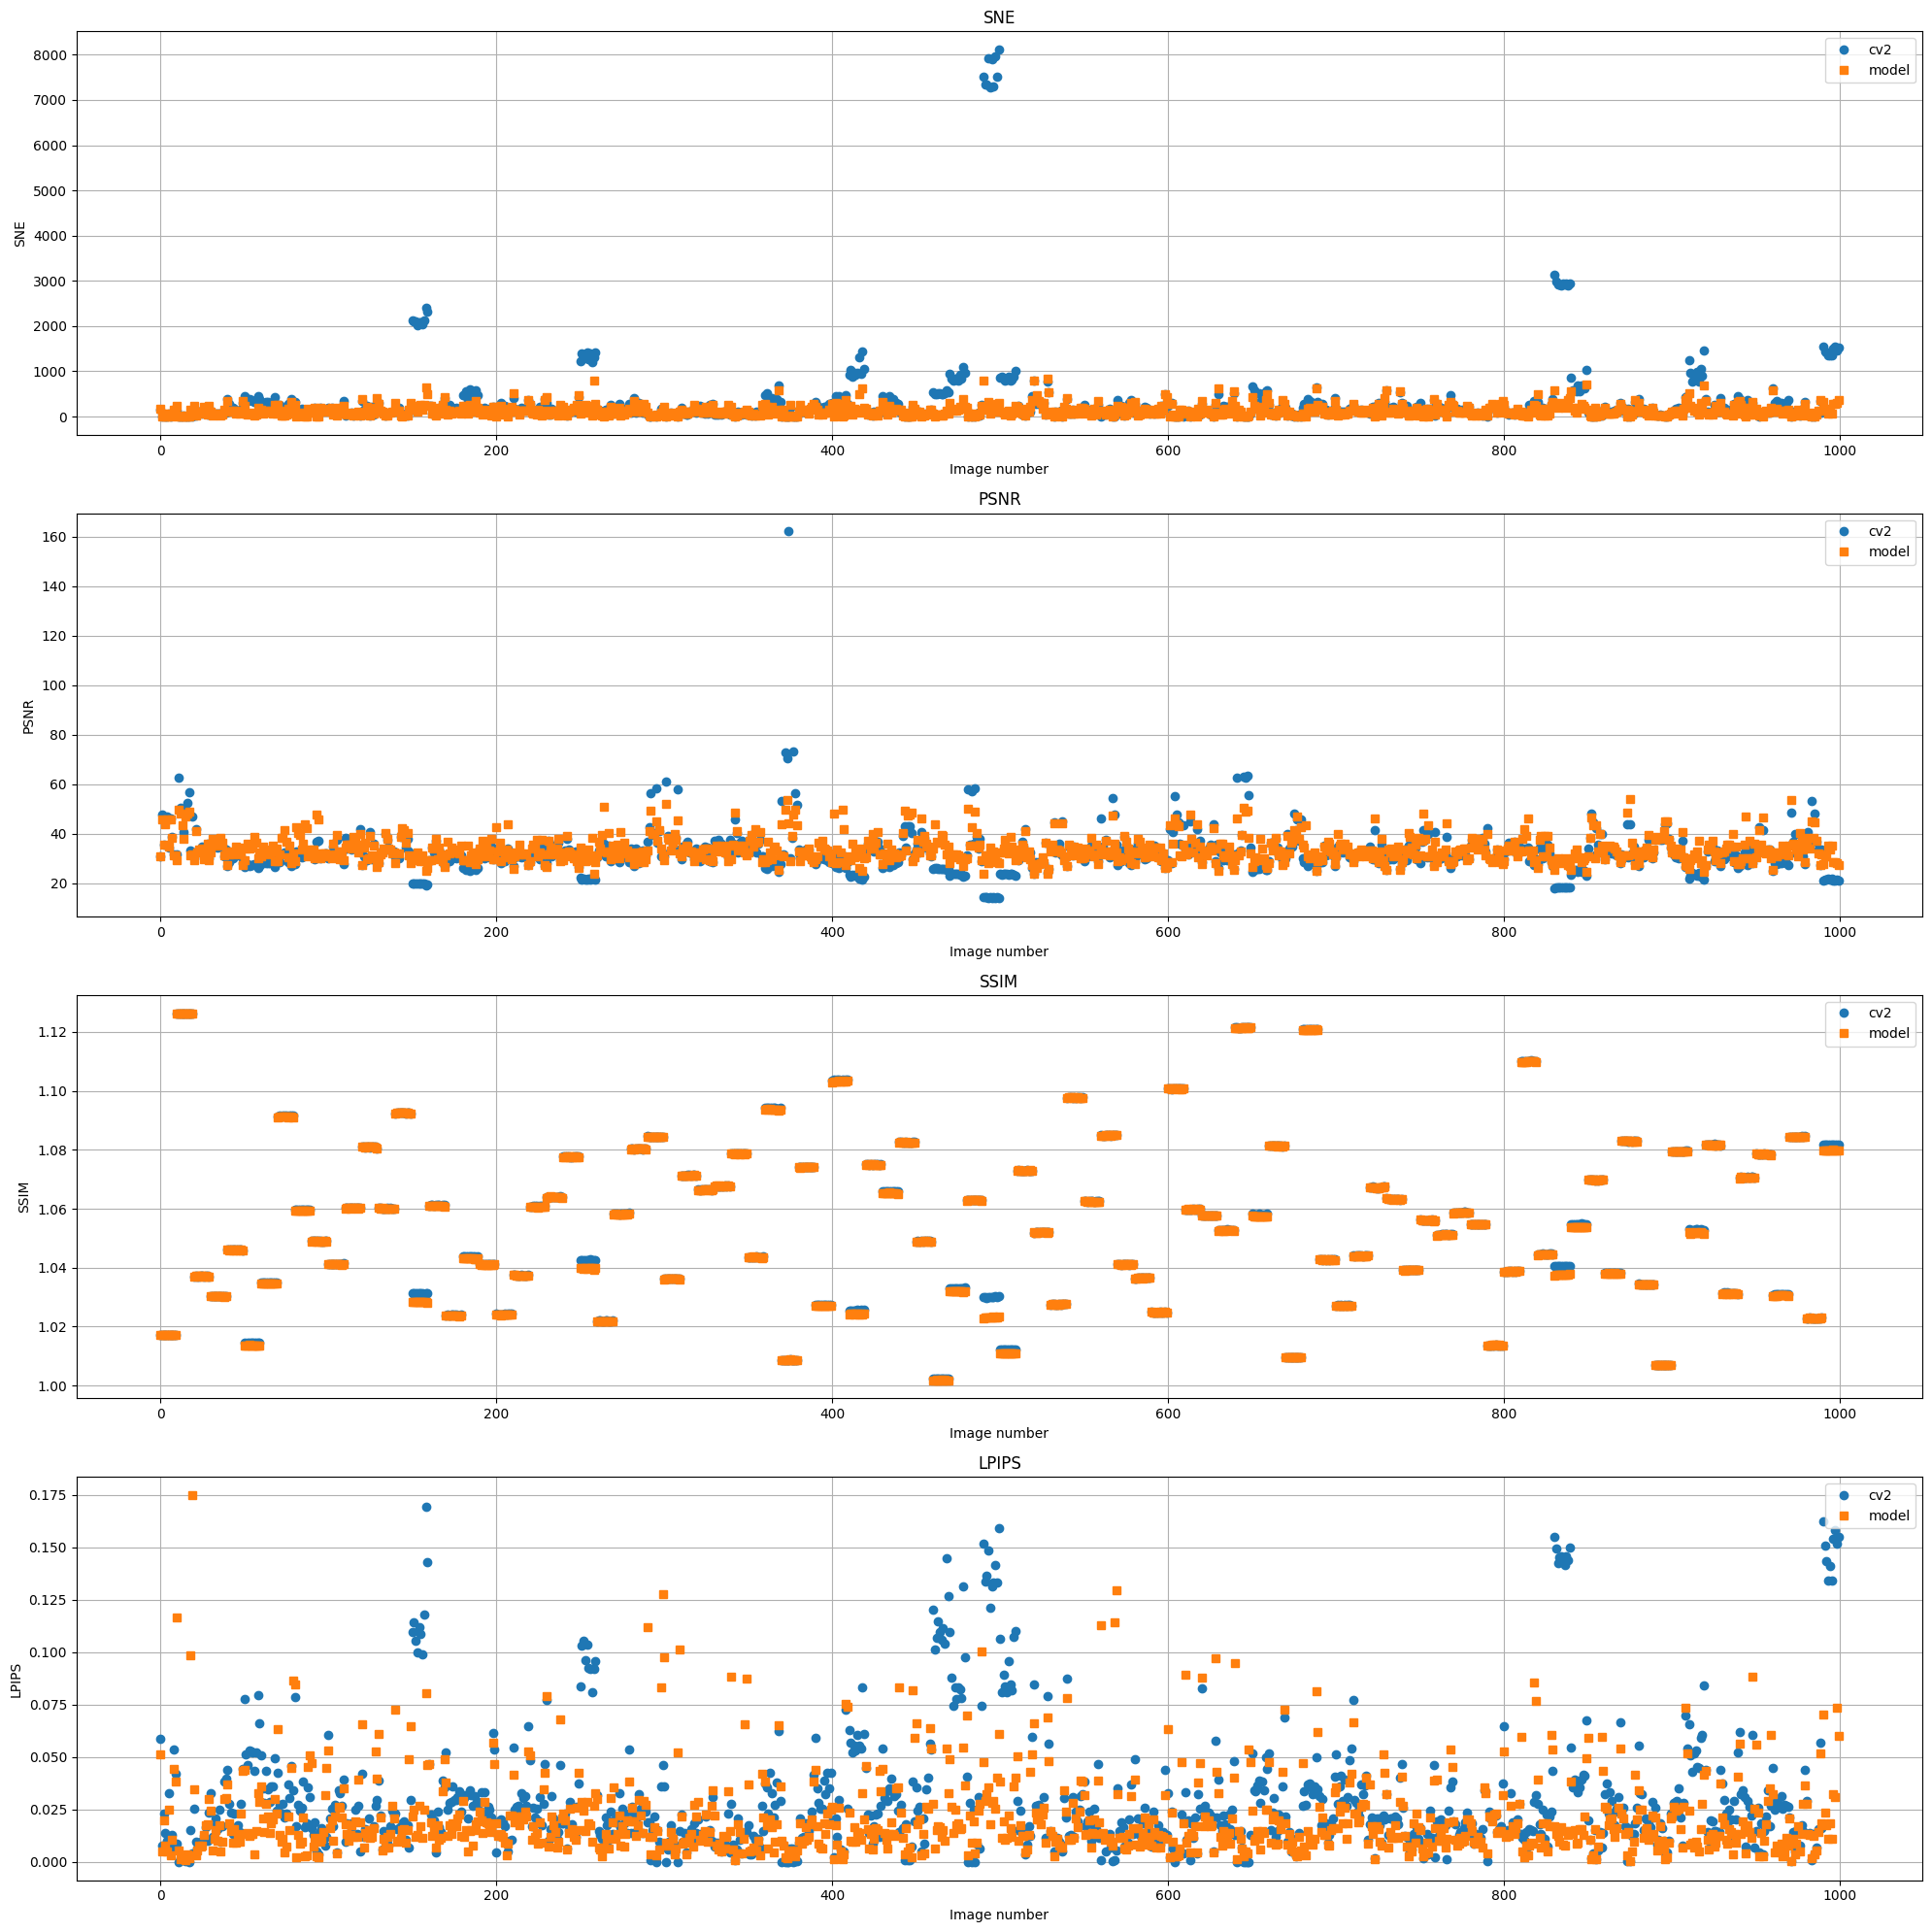

Metrics:
--------------------------------------------------
| Metric  | cv2        | Model      | Which Better
--------------------------------------------------
| SNE     |   343.1702 |   135.5275 | model
| PSNR    |    32.1451 |    33.6360 | model
| SSIM    |     1.0553 |     1.0549 | cv2
| LPIPS   |     0.0306 |     0.0212 | model
--------------------------------------------------


In [25]:
ground_truth_list = []
cv2_list = []
model_list = []

model.eval()

for x, y in valid_dataset:
    ground_truth_list.append(y.permute(1, 2, 0).detach().numpy())

    input = x.permute(1, 2, 0).detach().numpy()

    black_mask = (np.all(input < 0.05, axis=2)).astype(np.uint8) * 255

    cv2_list.append(classic_inpaint((input * 255).astype(np.uint8), black_mask))

    model_list.append(replace_black_squares(input, model(x.to(device)).permute(1, 2, 0).detach().cpu().numpy()))

plot_metrics(ground_truth_list, cv2_list, model_list)

Większość metryk dla stworzonego modelu wykazuje lepsze wyniki, a PSNR który jest tylko nieco lepszy w przypadku rozwiązania w cv2.